# Image generation using GAN

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling

## Memory growth for GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Load Images and augment data

Path to the dataset used and setting the image size and batch size:

In [3]:
img_height, img_width = 64, 64
batch_size = 32
train_datagen  = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    data_format="channels_last",
    brightness_range=[0.5, 1.5],
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
img_dir = "./../data/images/classes"  # Enter Directory of all images
train_generator = train_datagen.flow_from_directory(
    "./../data/images/classes",          # Directory path to the training dataset
    target_size=(img_height, img_width),   # Resize images to 150x150 pixels
    batch_size=32,            # Number of images to yield per batch
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    "./../data/images/classes",     # Directory path to the validation dataset
    target_size=(img_height, img_width),   # Resize images to 150x150 pixels
    batch_size=32,            # Number of images to yield per batch
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

Found 13 images belonging to 13 classes.
Found 13 images belonging to 13 classes.


In [5]:
num_classes = 13

## Test data augmentation on image classification

In [82]:
simple_classifier = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(
            num_classes, activation="softmax"
        ),  # 13 output neurons for 13 classes
    ]
)
simple_classifier.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = simple_classifier.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,  # Number of epochs to train
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)


Epoch 1/100


c:\Users\Ana\miniconda3\envs\hazmat-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Ana\miniconda3\envs\hazmat-env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0000e+00 - loss: 2.5607 - val_accuracy: 0.0769 - val_loss: 2.5383
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.0769 - loss: 2.5523 - val_accuracy: 0.0769 - val_loss: 2.5101
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0769 - loss: 2.5271 - val_accuracy: 0.2308 - val_loss: 2.4523
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.1538 - loss: 2.4731 - val_accuracy: 0.1538 - val_loss: 2.3584
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2308 - loss: 2.4196 - val_accuracy: 0.1538 - val_loss: 2.2475
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2308 - loss: 2.2898 - val_accuracy: 0.3077 - val_loss: 2.1495
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3077 - loss: 2.1563 - val_accuracy: 0.3077 - val_loss: 1.9608
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.2308 - loss: 2.0503 - val_accuracy: 0.3846 - val_loss:

In [83]:
from keras.models import save_model

save_model(simple_classifier, './../models/simple_classifier.keras')  # Save generator in native Keras format

In [7]:
# Example image path for prediction
img_path = './../data/images/classes/dangerous/6-dangerous.png'

# Load and preprocess the image
img = load_img(img_path, target_size=(img_height, img_width))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Rescale to [0, 1]
img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to create batch size of 1

In [8]:
predictions = simple_classifier.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [9]:
predicted_class_index = np.argmax(predictions[0])

In [10]:
class_labels = list(train_generator.class_indices.keys())  # Assuming train_generator is used for training
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

Predicted class: dangerous


# GAN network

## Build the Generator

## Imports

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2DTranspose, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def build_generator(latent_dim):
    model =Sequential()
    
   # Initial Dense layer
    model.add(Dense(256 * 8 * 8, input_dim=latent_dim))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Reshape((8, 8, 256)))
    
    # Upsampling to 16x16
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    
    # Upsampling to 32x32
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    
    # Upsampling to 64x64
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    
    # Final convolutional layer to generate 3 channels (RGB)
    model.add(Conv2D(3, kernel_size=3, activation='tanh', padding='same'))
   
    return model

In [13]:
latent_dim = 128

generator = build_generator(latent_dim)

c:\Users\Ana\miniconda3\envs\hazmat-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,165,955 (12.08 MB)

 Trainable params: 3,165,955 (12.08 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999789..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999734..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999288..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999887..1.0].


(4, 64, 64, 3)


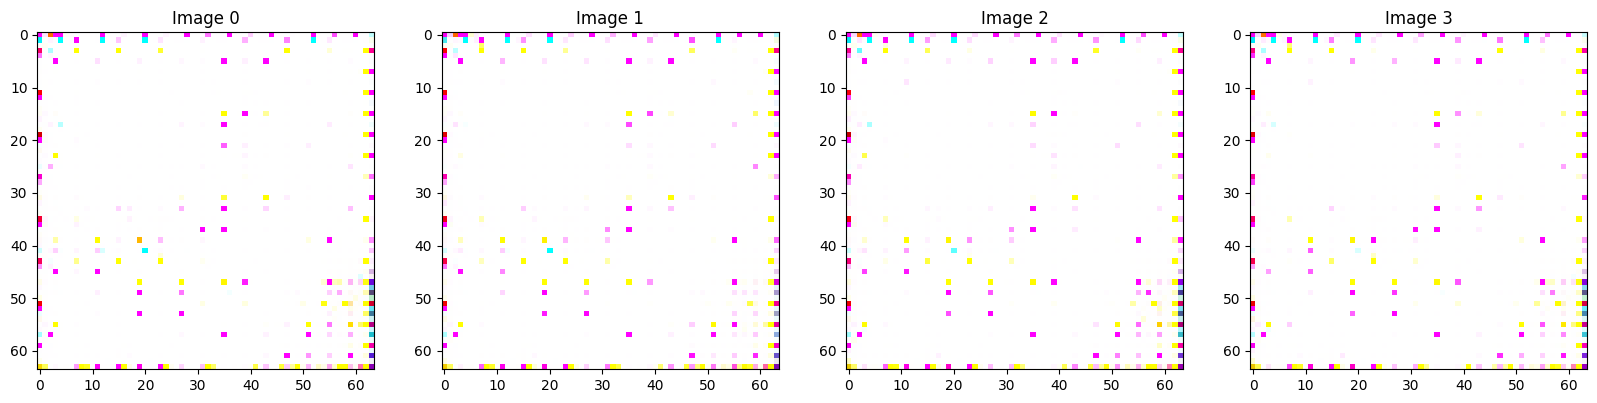

In [84]:
# Generate a batch of random noise vectors
noise = np.random.randn(4, latent_dim)  # 4 is the batch size

# Generate images from the noise vectors
generated_images = generator.predict(noise)

# Inspect the generated images
print(generated_images.shape)  # Should be (4, 200, 200, 3)

# Create subplots
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Display each generated image in a subplot
for idx, img in enumerate(generated_images):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(f"Image {idx}")

## Build the Discriminator

In [120]:
def build_discriminator(img_shape):
    model = Sequential()
    
    # Convolutional layers with Leaky ReLU activation
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))

    # Flatten and classify
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [121]:
from tensorflow.keras.models import load_model


img_shape=(img_height, img_width,3)
discriminator = build_discriminator(img_shape)

In [122]:
discriminator.summary()

Model: "functional_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ real_or_fake (Dense)            │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,559,169 (5.95 MB)

 Trainable params: 1,559,169 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
generated_image = generator.predict(noise)[0]

print(generated_image.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
(64, 64, 3)


In [124]:
#Confidence of discriminator before training: obviously not too confident ~49%
discriminator.predict(np.expand_dims(generated_image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[0.47591844]], dtype=float32)

## Train the discriminator

In [125]:
from tensorflow.keras.optimizers import Adam

discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])


In [133]:
# Create training image generator
train_generator = train_datagen.flow_from_directory(
    img_dir,                  # Directory path to the training dataset
    target_size=(img_height, img_width),   # Resize images to 64x64 pixels
    batch_size=batch_size,            # Number of images to yield per batch
    class_mode='binary',          # No labels are required since we are training on real images only
    shuffle=True              # Shuffle data
)

#Build and compile discriminator
img_shape = (img_height, img_width, 3)
discriminator = build_discriminator(img_shape)
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the discriminator
epochs = 100
steps_per_epoch = len(train_generator)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step in range(steps_per_epoch):
        imgs, labels = next(train_generator)
        d_loss = discriminator.train_on_batch(imgs, labels)
        print(f"Step {step+1}/{steps_per_epoch} - Discriminator Loss: {d_loss[0]}, Accuracy: {d_loss[1]}")
    
    # Print predictions after every epoch for inspection
    predictions = discriminator.predict(train_generator)
    print("Predictions:", predictions)


Found 13 images belonging to 13 classes.
Epoch 1/100
Step 1/1 - Discriminator Loss: 1.1510306596755981, Accuracy: 0.07692307978868484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predictions: [[0.5682137 ]
 [0.58326805]
 [0.5678202 ]
 [0.5870667 ]
 [0.5776701 ]
 [0.5747747 ]
 [0.57682794]
 [0.581953  ]
 [0.57720065]
 [0.57481444]
 [0.5618424 ]
 [0.59020287]
 [0.57450455]]
Epoch 2/100
Step 1/1 - Discriminator Loss: -0.10218624025583267, Accuracy: 0.07692307978868484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predictions: [[0.6603046 ]
 [0.6802877 ]
 [0.6735172 ]
 [0.6571798 ]
 [0.64400476]
 [0.66315085]
 [0.65568686]
 [0.65423626]
 [0.6410616 ]
 [0.6441016 ]
 [0.6722163 ]
 [0.67860425]
 [0.6627501 ]]
Epoch 3/100
Step 1/1 - Discriminator Loss: -1.2885609865188599, Accuracy: 0.07692307978868484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predictions: [[0.7748484 ]
 [0.7479719 ]
 [0.73352224]
 [0.78348285]
 [0.76226497]
 [0.7773327 ]
 [0.75306916]
 [0.7570677 ]
 [0.7840768 ]
 [0.73468757]
 [0.7608315 ]
 [0.

## Construct the Training Loop

## Imports

In [134]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import os
import numpy as np


In [135]:
# Define the optimizers and losses
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [136]:
# Subclassed Model for GAN
class TrainGAN(Model):
    def __init__(self, generator, discriminator, g_opt, d_opt, g_loss, d_loss, latent_dim=128, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.latent_dim = latent_dim

    def train_step(self, batch):
        real_images = batch  # Extract images (no labels)
        #batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal((128, self.latent_dim), mean=0, stddev=100)

        # Generate fake images
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            gen_images = self.generator(random_noise, training=True)
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(gen_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            y_realfake = tf.concat([tf.ones_like(yhat_real), tf.zeros_like(yhat_fake)], axis=0)

            # Adding noise to labels for discriminator
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [137]:
# Define a callback to save generated images during training
class ModelMonitor(Callback):
    def __init__(self, generator, num_img=3, latent_dim=128, save_dir='./../data/images/generated', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5 + 127.5).numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(self.save_dir, f'generated_img_{epoch}_{i}.png'))

In [138]:
# Create the GAN model instance
gan = TrainGAN(generator, discriminator, g_opt, d_opt, g_loss, d_loss)
gan.compile(optimizer=g_opt, loss=g_loss)

## Train

In [140]:
# Train the GAN
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_ds = train_datagen.flow_from_directory(
    './../data/images/classes',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None  # No labels for GAN training
)

hist = gan.fit(train_ds, epochs=500, callbacks=ModelMonitor(generator))


Found 13 images belonging to 13 classes.
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 15.4121 - g_loss: 0.0000e+00
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 15.4803 - g_loss: 0.0000e+00
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 15.4364 - g_loss: 0.0000e+00
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 15.5565 - g_loss: 0.0000e+00
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 15.4840 - g_loss: 0.0000e+00
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 15.5655 - g_loss: 0.0000e+00
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 15.4021 - g_loss: 0.0000e+00
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 15.5574 - g_loss: 0.0000e+00
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 15.4604 - g_loss: 0.0000e+00
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 15.4277 - g_loss: 0.0000e+00
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 15.4308 - g_loss: 0.0000e+00


In [ ]:
from keras.models import save_model

save_model(generator, './../models/generator.keras')  # Save generator in native Keras format
save_model(discriminator, './../models/discriminator.keras')  # Save discriminator in native Keras format

## Review Performance

In [ ]:
generator.load_weights(os.path.join('archive', './../models/generator.keras'))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'archive\./../models/generator.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## Test Out the Generator

In [ ]:
noise = np.random.randn(4, 128)  # 4 is the batch size, 128 is the dimension of the noise vector

# Generate images from the noise vectors
generated_images = generator.predict(noise)

# Inspect the generated images
print(generated_images.shape)  # Should be (4, 200, 200, 3)

# Create subplots
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Display each generated image in a subplot
for idx, img in enumerate(generated_images):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(f"Image {idx}")